In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


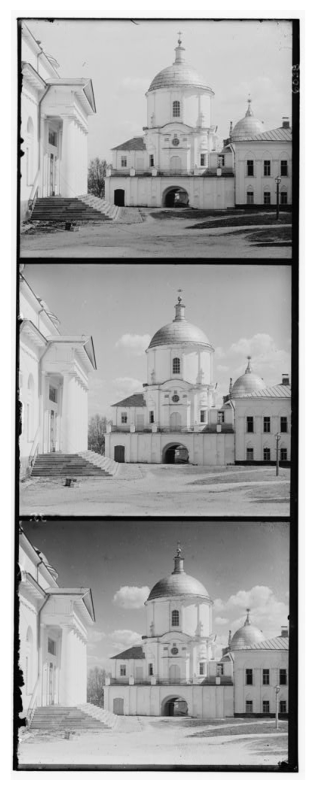

In [3]:
# Let's start with a single image
image1 = cv2.imread("Part_A/InputImages/01112v.jpg", cv2.IMREAD_GRAYSCALE)

fig, axs = plt.subplots(1, 1, figsize=(5, 10))
axs.imshow(image1, cmap="gray")
axs.set_axis_off()
#fig.savefig("Images/original1.png")
plt.show()

In [4]:
# Print the object type and shape
print(type(image1))
print(image1.shape)

<class 'numpy.ndarray'>
(1024, 393)


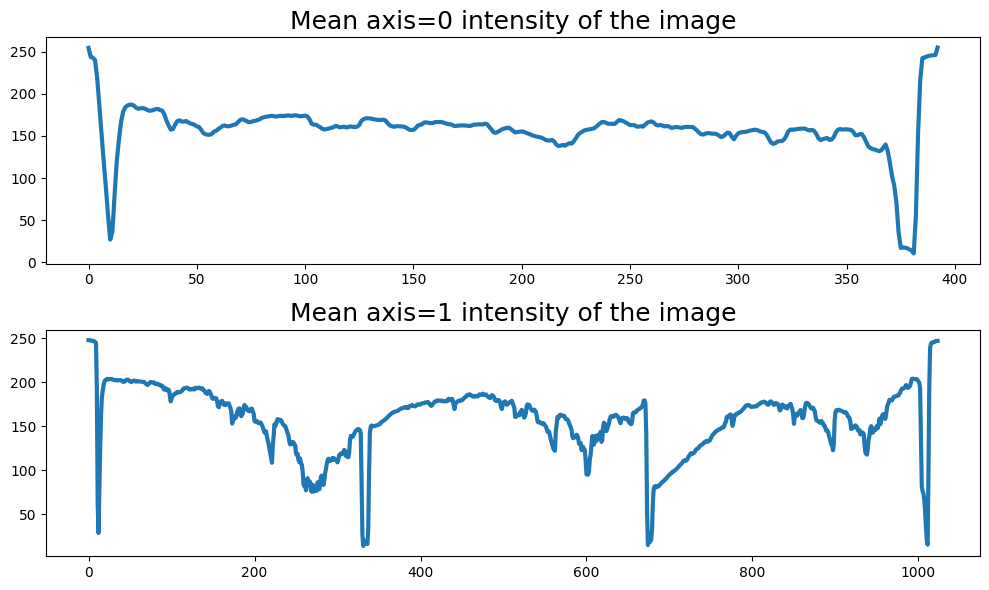

In [5]:
# Plot the histogram
mean_vert = np.mean(image1, axis=0)
mean_hor = np.mean(image1, axis=1)


# Plot the mean values
fig, axs = plt.subplots(2, 1, figsize=(10, 6))
axs[0].plot(np.arange(image1.shape[1]), mean_vert, linewidth=3)
axs[1].plot(np.arange(image1.shape[0]), mean_hor, linewidth=3)
axs[0].set_title("Mean axis=0 intensity of the image", fontsize=18)
axs[1].set_title("Mean axis=1 intensity of the image", fontsize=18)
fig.tight_layout()
#fig.savefig("Images/mean_per_axis1.svg", format="svg")
plt.show()

### In all images the border surrounding the actual Image is black. From the Plots above we are selecting a threshold value of $thresh = 45$, to denote image areas belong to the border. 

#### To identify the exact points in the whole image that represent SubImage corners we will identify these pairs of horitontal and vertical coordinates where we move from a border area to a non border area and the opposite

4 8


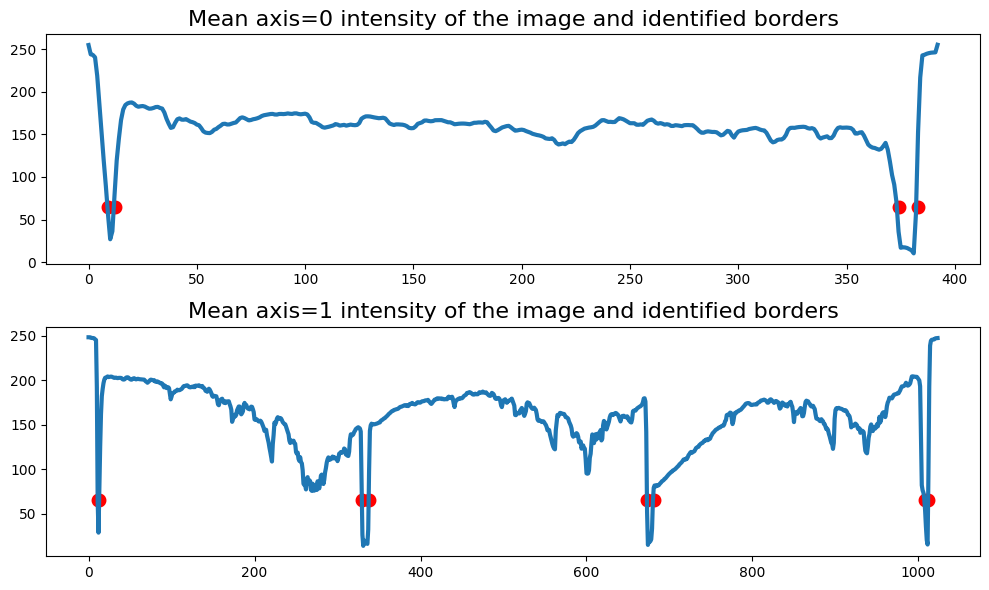

In [6]:
thresh = 65
hor_coordinates = [i for i in range(image1.shape[1]) if mean_vert[i] <= thresh and mean_vert[i-1] > thresh or mean_vert[i] > thresh and mean_vert[i-1] <= thresh]
vert_coordinates = [i for i in range(image1.shape[0]) if mean_hor[i] <= thresh and mean_hor[i-1] > thresh or mean_hor[i] > thresh and mean_hor[i-1] <= thresh]
print(len(hor_coordinates), len(vert_coordinates))


# Plot the above points on top of the previous figures
fig, axs = plt.subplots(2, 1, figsize=(10, 6))
axs[0].plot(np.arange(image1.shape[1]), mean_vert, linewidth=3)
axs[1].plot(np.arange(image1.shape[0]), mean_hor, linewidth=3)
axs[0].scatter(hor_coordinates, thresh * np.ones_like(np.array(hor_coordinates)), linewidth=4, color="red")
axs[1].scatter(vert_coordinates, thresh * np.ones_like(np.array(vert_coordinates)), linewidth=4, color="red")
axs[0].set_title("Mean axis=0 intensity of the image and identified borders", fontsize=16)
axs[1].set_title("Mean axis=1 intensity of the image and identified borders", fontsize=16)
fig.tight_layout()
#fig.savefig("Images/mean_per_axis_with_borders1.svg", format="svg")
plt.show()

#### First we will remove the coordinates with index $0$ and $-1$, as they represent the points where we enter the black border areas from the white super-border. These points are not of interest. 

#### Then, we will combine the $(x,y)$ coordinates by taking subsequent pairs of vertical coordinates and combining them with both horizontal coordinates

2 6


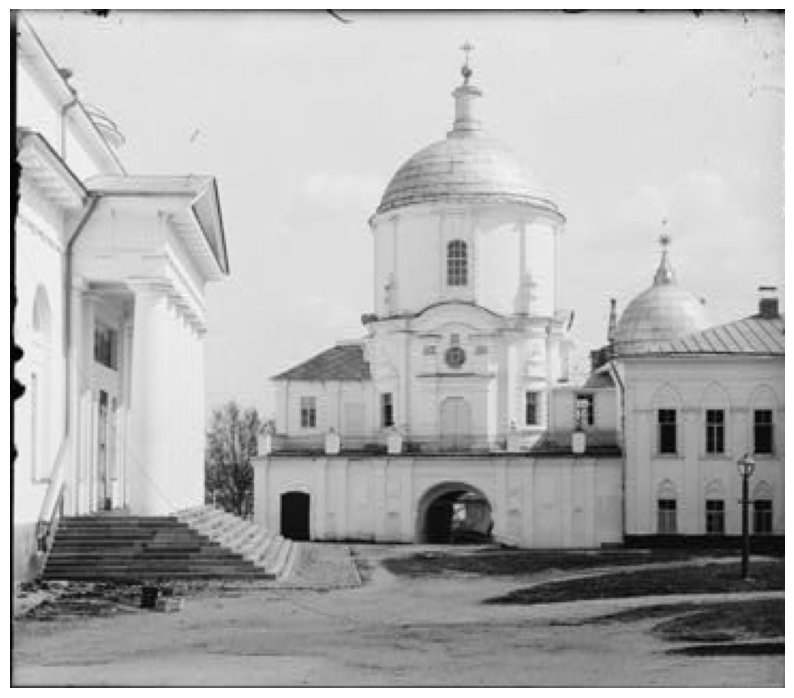

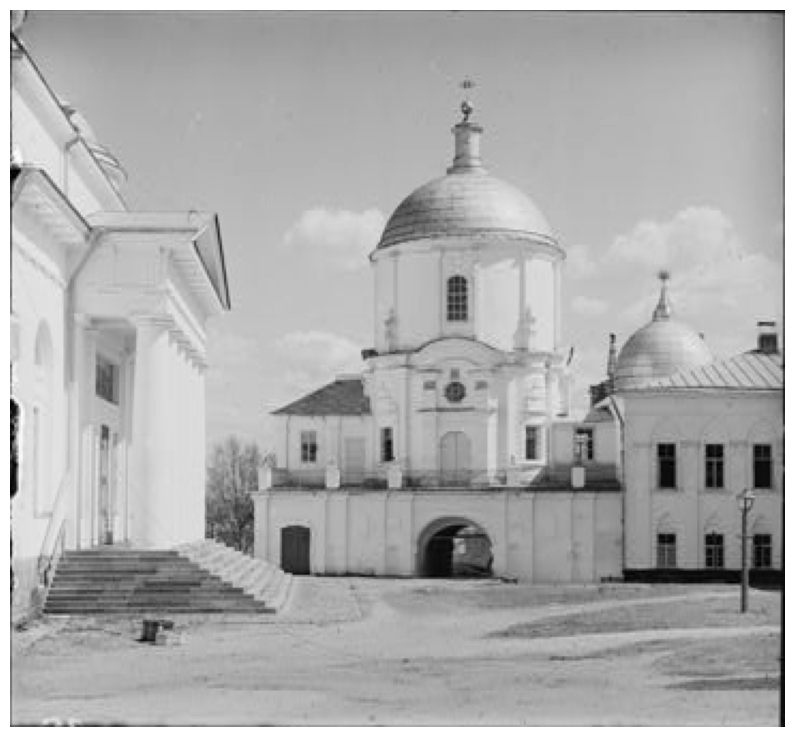

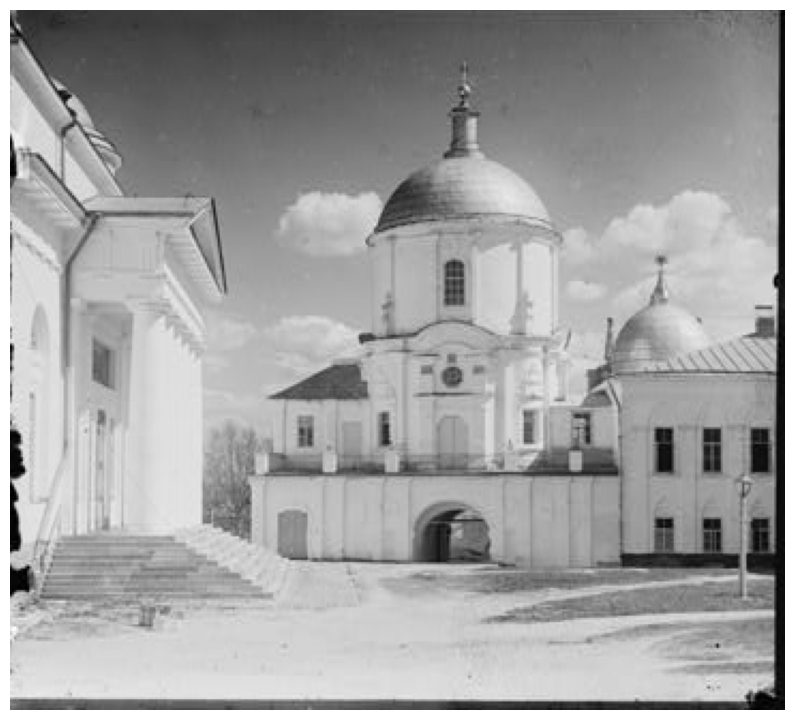

In [10]:
x_coords = hor_coordinates[1:-1]
y_coords = vert_coordinates[1:-1]
print(len(x_coords), len(y_coords))

img_coords = [[[y_coords[i], x_coords[0]], [y_coords[i], x_coords[1]], [y_coords[i+1], x_coords[0]], [y_coords[i+1], x_coords[1]]] for i in range(0, len(y_coords), 2)]


# Get cropped images and display them
images = []
for i, subimage in enumerate(img_coords):
    image = image1[subimage[0][0]:subimage[2][0], subimage[0][1]:subimage[3][1]]
    images.append(image)
    fig, axs = plt.subplots(1, 1, figsize=(10, 10))
    axs.imshow(image, cmap="gray")
    axs.set_axis_off()
    #fig.savefig("Images/cropped1{}.png".format(i))
    plt.show()

### Now, we will zero-pad the first image with 30 pixels and we are going to exhaustively search for the minimum of pair-wise inner-product for different horizontal and vertical shifts between the rest of the images


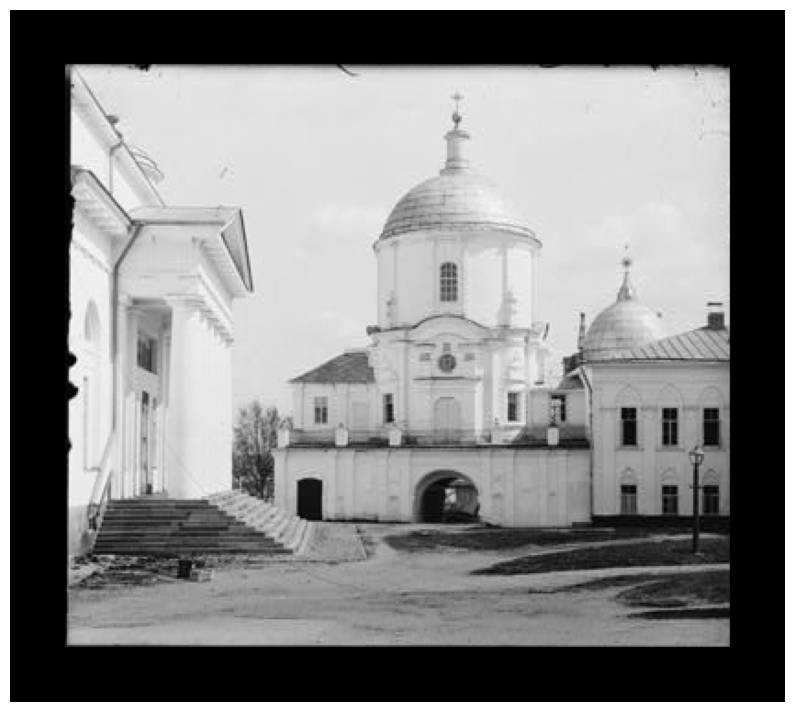

In [8]:
first_padded_image = np.pad(images[0], ((30, 30), (30, 30)), constant_values=0)
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
axs.imshow(first_padded_image, cmap="gray")
axs.set_axis_off()
#fig.savefig("Images/padded_image.png")
plt.show()


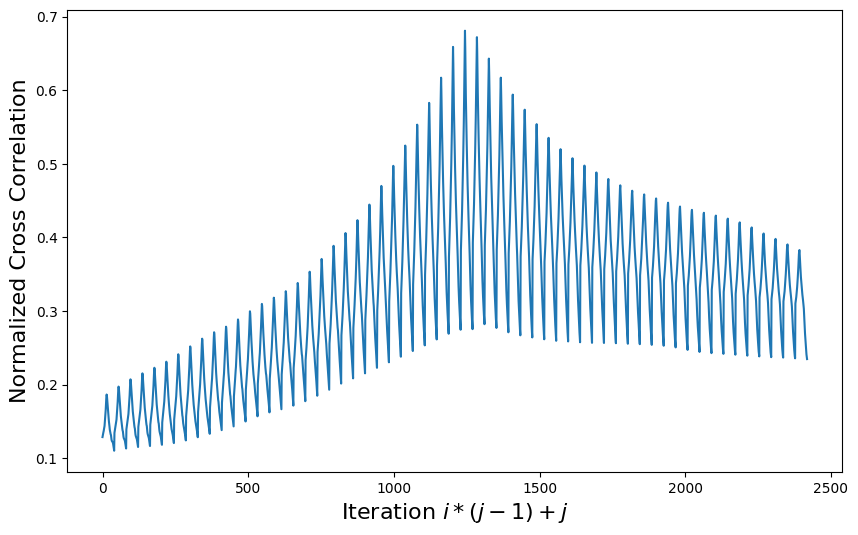

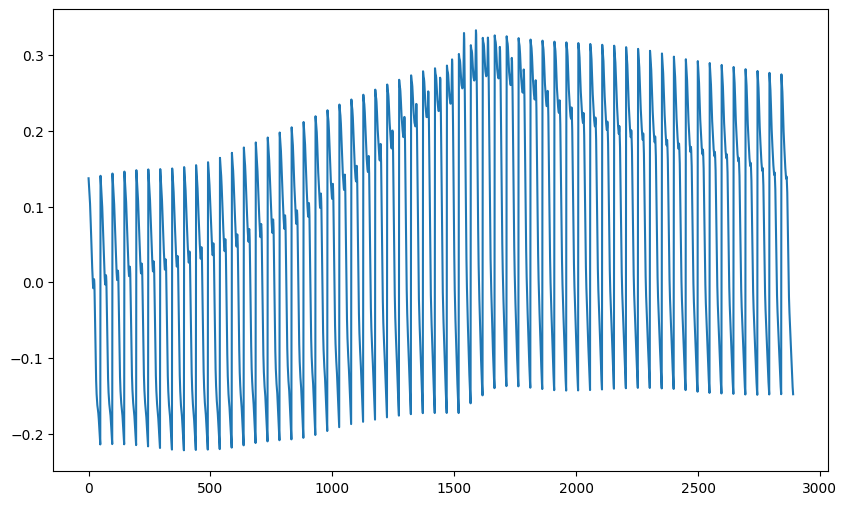

30 32 14 21
[(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


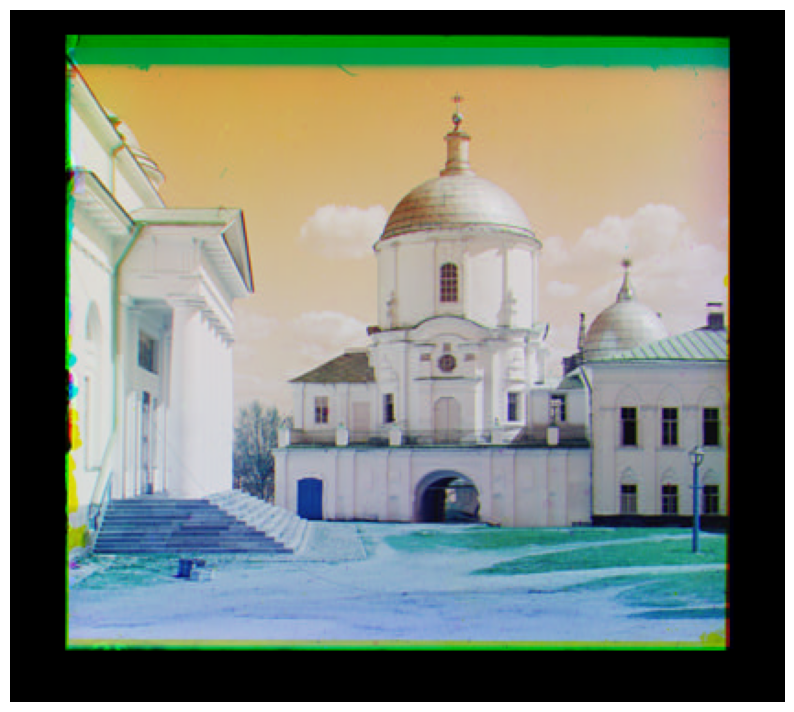

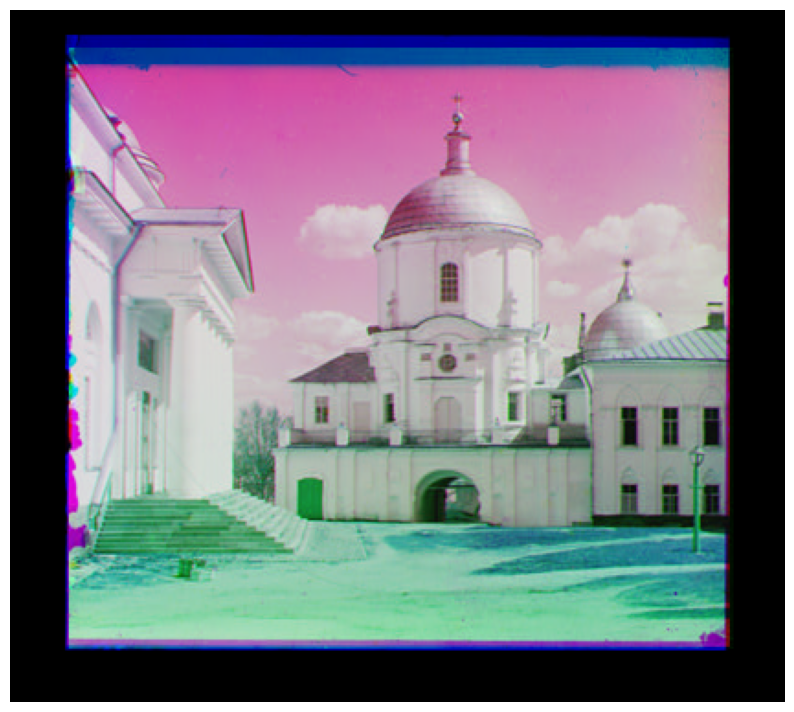

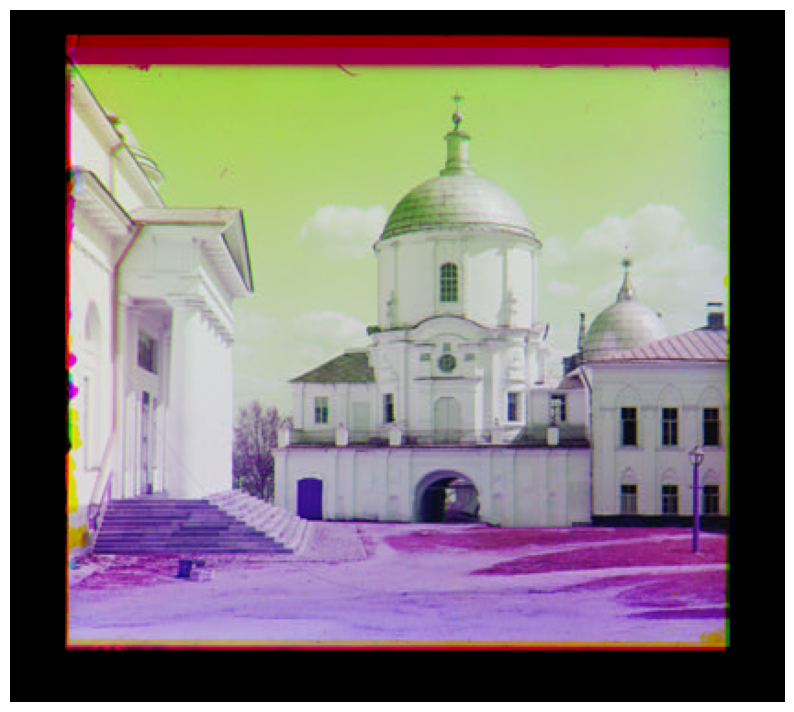

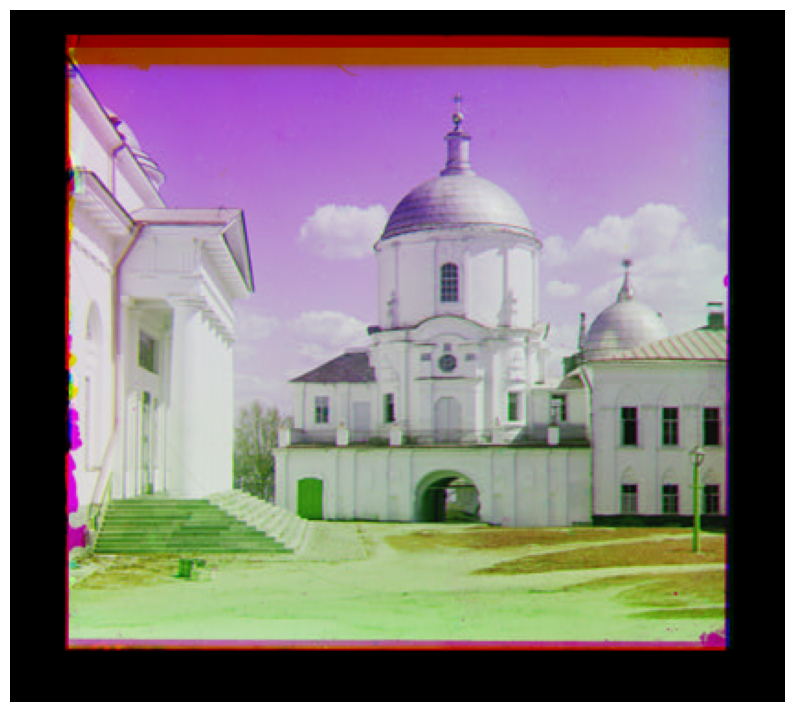

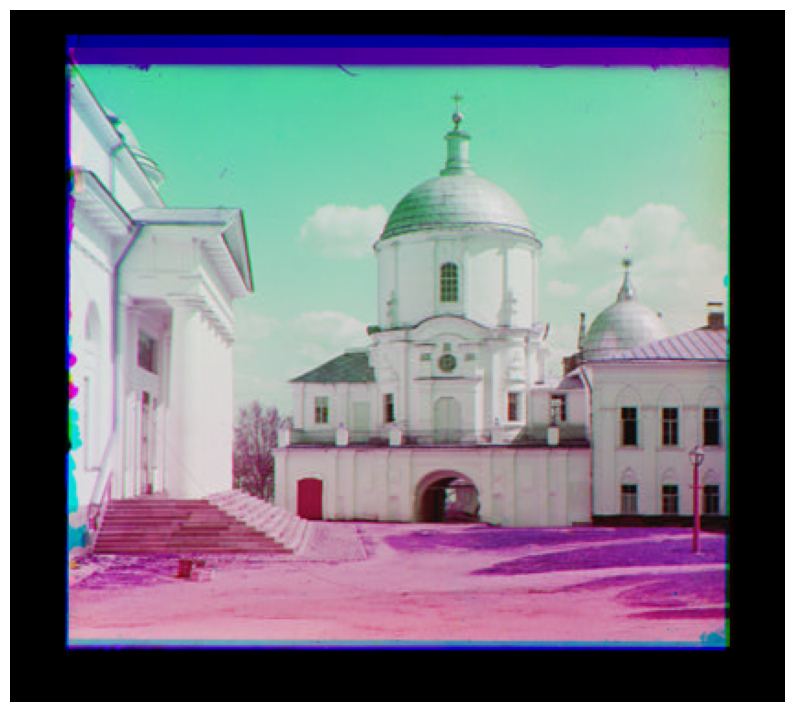

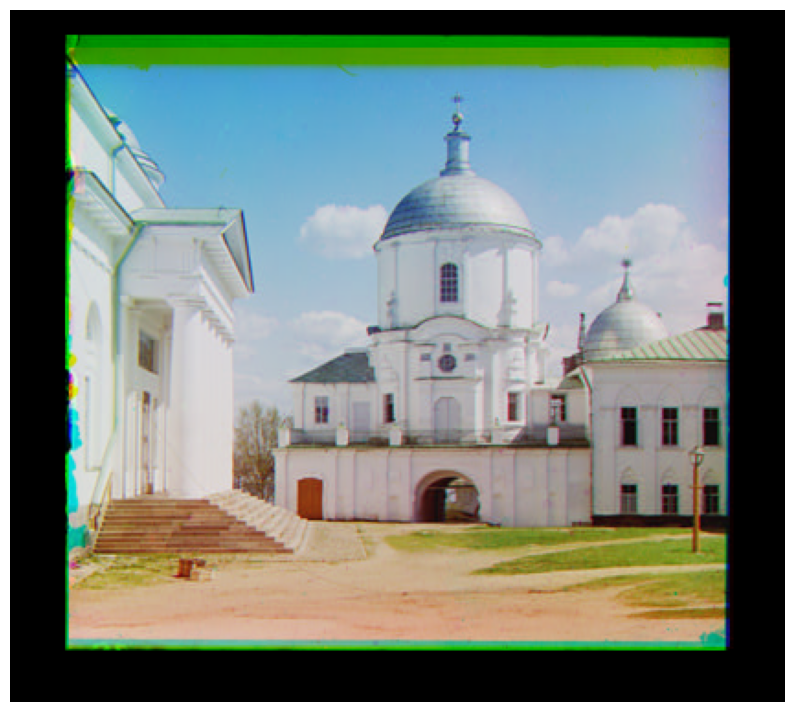

In [9]:
import itertools

def NCC(f, g, x, y):
    len_x = g.shape[1]
    len_y = g.shape[0]
    mu_f = np.mean(f[y:y+len_y, x:x+len_x])
    mu_g = np.mean(g)
    sigma_f = np.std(f[y:y+len_y, x:x+len_x])
    sigma_g = np.std(g)
    N = np.sum(g.shape)
    ncc = np.mean(np.multiply((f[y:y+len_y, x:x+len_x] - mu_f) / sigma_f, (g - mu_g) / sigma_g))

    return ncc


# Find highest inner product and match first and second picture
nccs = []
max_ncc = 0
for x in range(first_padded_image.shape[1] - images[1].shape[1] - 1):
    for y in range(first_padded_image.shape[0] - images[1].shape[0] - 1):
        ncc = NCC(first_padded_image, images[1], x, y)
        nccs.append(ncc)
        if ncc >= max_ncc:
            max_ncc = ncc
            x_max1 = x
            y_max1 = y    

fig, axs = plt.subplots(1, 1, figsize=(10, 6))
axs.plot(range(len(nccs)), nccs)
axs.set_xlabel("Iteration $i*(j-1) + j$", fontsize=16)
axs.set_ylabel("Normalized Cross Correlation", fontsize=16)
#fig.savefig("Images/cross_correlation.svg", format="svg")
plt.show()

# Repeat the same for the third picture
max_ncc = 0
nccs = []
for x in range(first_padded_image.shape[1] - images[2].shape[1] - 1):
    for y in range(first_padded_image.shape[0] - images[2].shape[0] - 1):
        ncc = NCC(first_padded_image, images[2], x, y)
        nccs.append(ncc)
        if ncc >= max_ncc:
            max_ncc = ncc
            x_max2 = x
            y_max2 = y      

fig, axs = plt.subplots(1, 1, figsize=(10, 6))
axs.plot(range(len(nccs)), nccs)
plt.show()

print(x_max1, x_max2, y_max1, y_max2)

image2 = np.zeros_like(first_padded_image)
image2[y_max1:y_max1+images[1].shape[0], x_max1:x_max1+images[1].shape[1]] = images[1]
image3 = np.zeros_like(first_padded_image)
image3[y_max2:y_max2+images[2].shape[0], x_max2:x_max2+images[2].shape[1]] = images[2]

new_images = [first_padded_image, image2, image3]
perms = list(itertools.permutations([0, 1, 2], 3))
print(perms)
for i, perm in enumerate(perms):
    rgb_image = np.dstack((new_images[perm[0]], new_images[perm[1]], new_images[perm[2]]))
    
    fig, axs = plt.subplots(1, 1, figsize=(10, 10))
    axs.imshow(rgb_image)
    axs.set_axis_off()
    fig.savefig("Images/rgb5{}.png".format(i))
    plt.show()

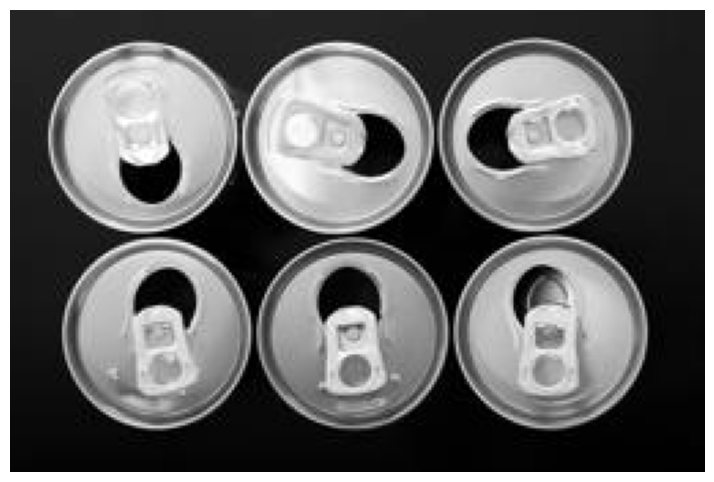

In [11]:
# PART B: Getting can.jpg file
image = cv2.imread("Part_B/can.jpg", cv2.IMREAD_GRAYSCALE)

fig, axs = plt.subplots(1, 1, figsize=(10, 6))
axs.imshow(image, cmap="gray")
axs.set_axis_off()
#fig.savefig("Images/can.jpg")
plt.show()

### Now we need to binarize the image

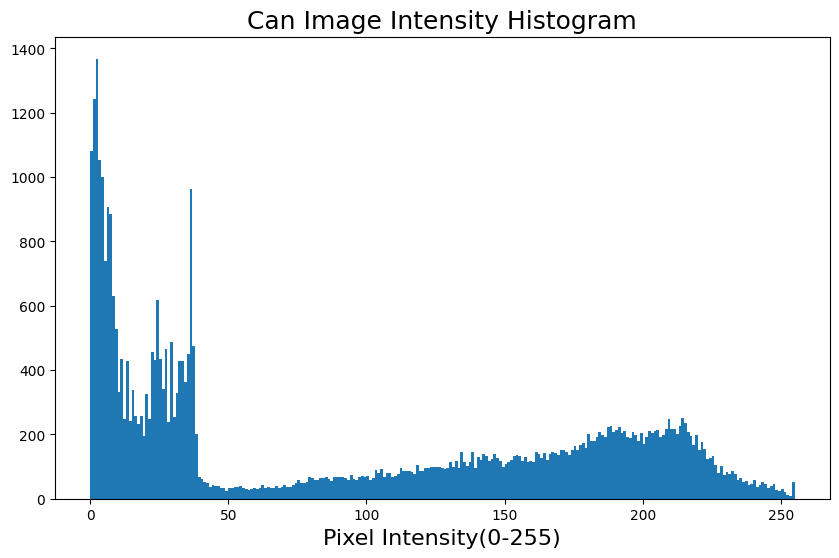

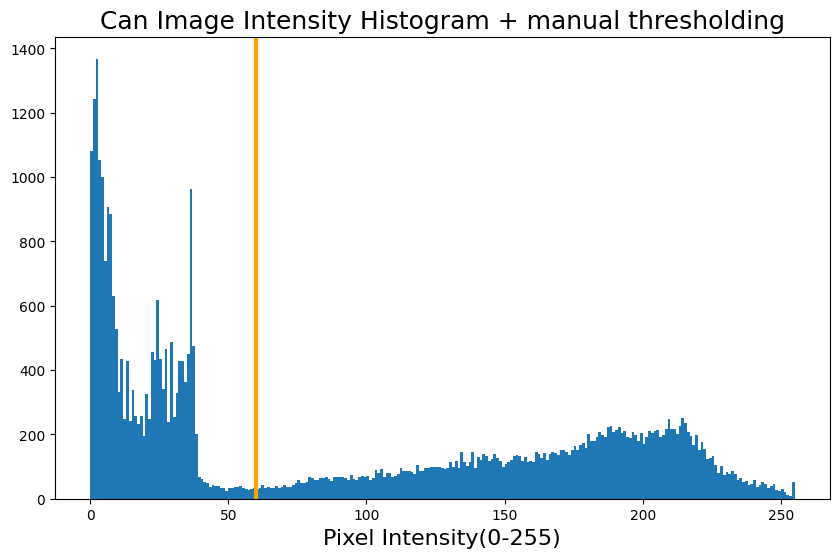

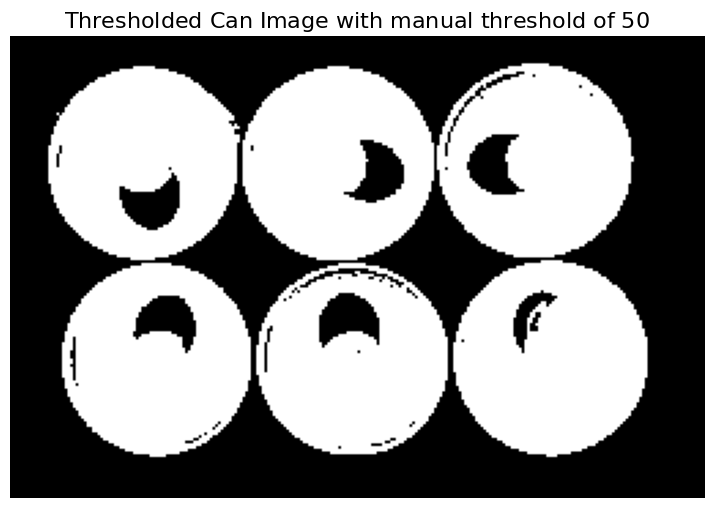

In [12]:
# Let us first get a histogram of image intensities
fig, axs = plt.subplots(1, 1, figsize=(10, 6))
axs.hist(image.flatten(), bins=255)
axs.set_title("Can Image Intensity Histogram", fontsize=18)
axs.set_xlabel("Pixel Intensity(0-255)", fontsize=16)
fig.savefig("Images/hist.svg", format="svg")

ret, bin_image = cv2.threshold(image, 60, 255, cv2.THRESH_BINARY)

# Let us first get a histogram of image intensities
fig, axs = plt.subplots(1, 1, figsize=(10, 6))
axs.hist(image.flatten(), bins=255)
axs.set_title("Can Image Intensity Histogram + manual thresholding", fontsize=18)
axs.set_xlabel("Pixel Intensity(0-255)", fontsize=16)
axs.axvline(ret, color="orange", linewidth=3)
fig.savefig("Images/hist_thresh_manual.svg", format="svg")
plt.show()

# Threshold with an obvious choice of around 40-50 intensity

fig, axs = plt.subplots(1, 1, figsize=(10, 6))
axs.imshow(bin_image, cmap="gray")
axs.set_axis_off()
axs.set_title("Thresholded Can Image with manual threshold of $50$", fontsize=16)
fig.savefig("Images/thresh_manual.png")
plt.show()

### From the histogram one can see that a threshold value of around $thresh \in (40, 50)$, separates well the two modes.
- #### Let's automate the process using Otsu's method

Otsu's threshold is:  100


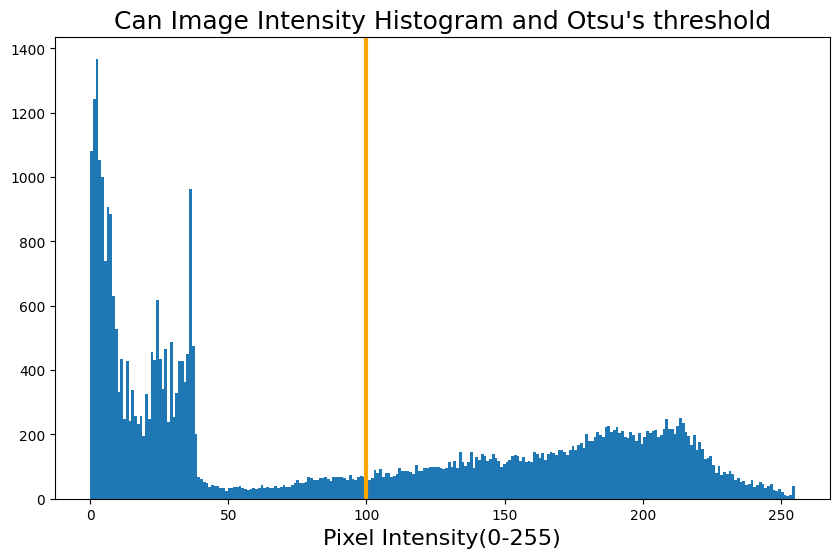

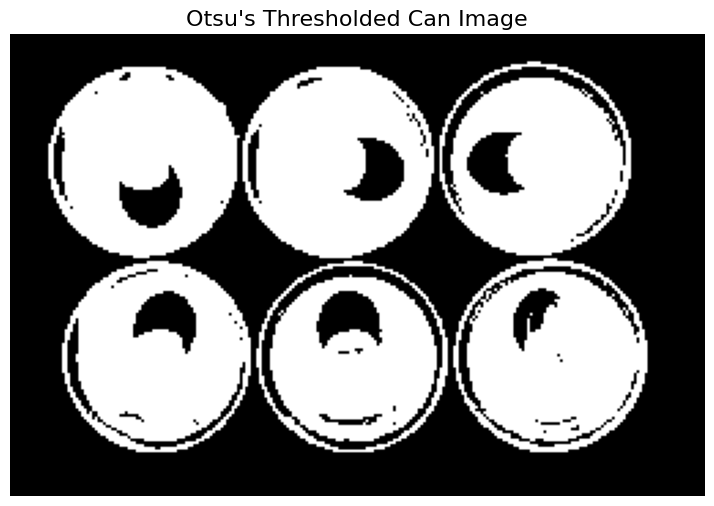

In [13]:
# Custom Otsu's implementation
def otsus_thresholding(image):
    flat_image = image.flatten()
    histogram, _ = np.histogram(flat_image, bins=256, range=(0, 256), density=True)

    # Initialization
    max_sigma = 0
    p1 = 0
    p2 = 1
    sumT = np.sum(np.arange(256) * histogram)
    sumF = 0
    mu1 = 0
    for i in range(256):
        p1 += histogram[i]
        if p1 == 0:
            continue
        p2 = 1 - p1
        if p2 == 0:
            break
        sumF += i * histogram[i]

        mu1 = sumF / p1
        mu2 = (sumT - sumF) / p2
        sigma_B = p1 * p2 * (mu1 - mu2) ** 2 
        
        if sigma_B > max_sigma:
            max_sigma = sigma_B
            best_thresh = i

    # Apply threshold
    _, bin_image = cv2.threshold(image, best_thresh, 255, cv2.THRESH_BINARY)
    return best_thresh, bin_image



thresh, bin_image = otsus_thresholding(image)

print("Otsu's threshold is: ", thresh)

# Let us first get a histogram of image intensities
fig, axs = plt.subplots(1, 1, figsize=(10, 6))
axs.hist(image.flatten(), bins=256)
axs.set_title("Can Image Intensity Histogram and Otsu's threshold", fontsize=18)
axs.set_xlabel("Pixel Intensity(0-255)", fontsize=16)
axs.axvline(thresh, color="orange", linewidth=3)
fig.savefig("Images/otsus_hist.svg", format="svg")
plt.show()


fig, axs = plt.subplots(1, 1, figsize=(10, 6))
axs.imshow(bin_image, cmap="gray")
axs.set_axis_off()
axs.set_title("Otsu's Thresholded Can Image", fontsize=16)
fig.savefig("Images/thresh_otsus.png")
plt.show()

thresh, bin_image = cv2.threshold(image, 50, 255, cv2.THRESH_BINARY)


### The threshold value is different than mine but still a reasonable choice

### Let's now proceed with morphological filtering

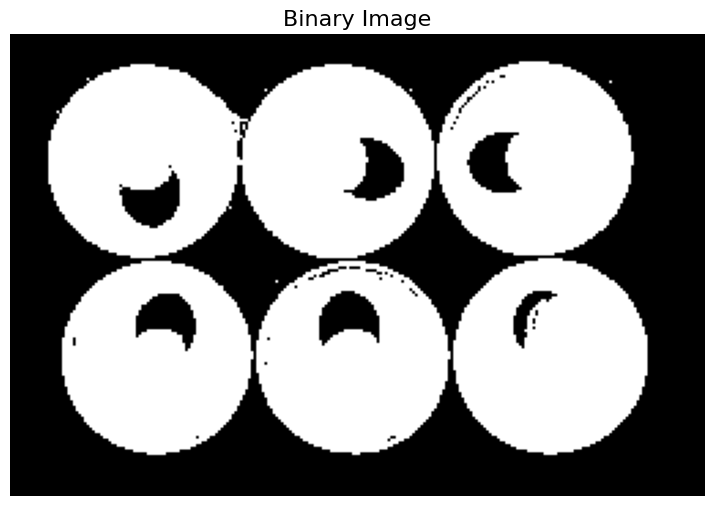

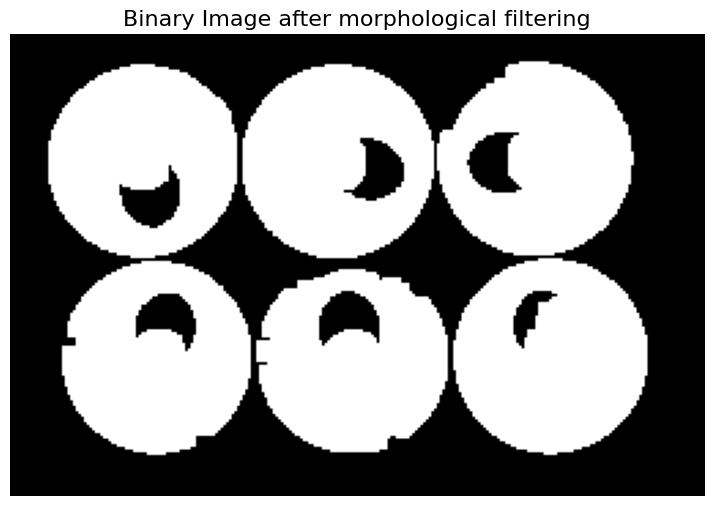

In [14]:
# We would like to fill in some circular artifacts and pixel holes in the images. Thus, we will use the Closing morphological operation
'''
def erosion(image, kernel_size=3):
    x = image.shape[1]
    y = image.shape[0]
    kernel = 255 * np.ones((kernel_size, kernel_size))
    center = kernel_size // 2
    eroded_image = 255 * np.ones_like(image)
    for i in range(center, y - center):
        for j in range(center, x - center):
            if np.any(image[i-center:i+center+1, j-center:j+center+1] == np.zeros_like(kernel)):
                eroded_image[i, j] = 0
    
    return eroded_image
'''
def erosion(image, kernel_size=3):
    pad = kernel_size // 2
    padded_image = np.pad(image, pad, constant_values=0)
    x = image.shape[1] + kernel_size - 1
    y = image.shape[0] + kernel_size - 1
    kernel = 255 * np.ones((kernel_size, kernel_size))
    center = kernel_size // 2
    eroded_image = 255 * np.ones_like(image)
    for i in range(center, y - center):
        for j in range(center, x - center):
            if np.any(padded_image[i-center:i+center+1, j-center:j+center+1] == np.zeros_like(kernel)):
                eroded_image[i - center, j - center] = 0
    
    return eroded_image


def dilation(image, kernel_size=3):
    pad = kernel_size // 2
    padded_image = np.pad(image, pad, constant_values=0)
    x = image.shape[1] + kernel_size - 1
    y = image.shape[0] + kernel_size - 1
    kernel = 255 * np.ones((kernel_size, kernel_size))
    center = kernel_size // 2
    dilated_image = np.zeros_like(image)
    for i in range(center, y - center):
        for j in range(center, x - center):
            if np.any(padded_image[i-center:i+center+1, j-center:j+center+1] == kernel):
                dilated_image[i - center, j - center] = 255
    
    return dilated_image

def opening(image, kernel_erosion=3, kernel_dilation=3):
    eroded_image = erosion(image, kernel_size=kernel_erosion)
    dilated_image = dilation(eroded_image, kernel_size=kernel_dilation)
    return dilated_image

def closing(image, kernel_erosion=5, kernel_dilation=3):
    dilated_image = dilation(image, kernel_size=kernel_dilation)
    eroded_image = erosion(dilated_image, kernel_size=kernel_erosion)
    return eroded_image


morph_image = opening(bin_image, kernel_erosion=5, kernel_dilation=3)
morph_image = closing(morph_image, kernel_erosion=3, kernel_dilation=3)
morph_image = dilation(morph_image, kernel_size=3)

fig, axs = plt.subplots(1, 1, figsize=(10, 6))
axs.imshow(bin_image, cmap="gray")
axs.set_axis_off()
axs.set_title("Binary Image", fontsize=16)
fig.savefig("Images/binary_image.png")
plt.show()

fig, axs = plt.subplots(1, 1, figsize=(10, 6))
axs.imshow(morph_image, cmap="gray")
axs.set_axis_off()
axs.set_title("Binary Image after morphological filtering", fontsize=16)
fig.savefig("Images/Binary_after.png")
plt.show()



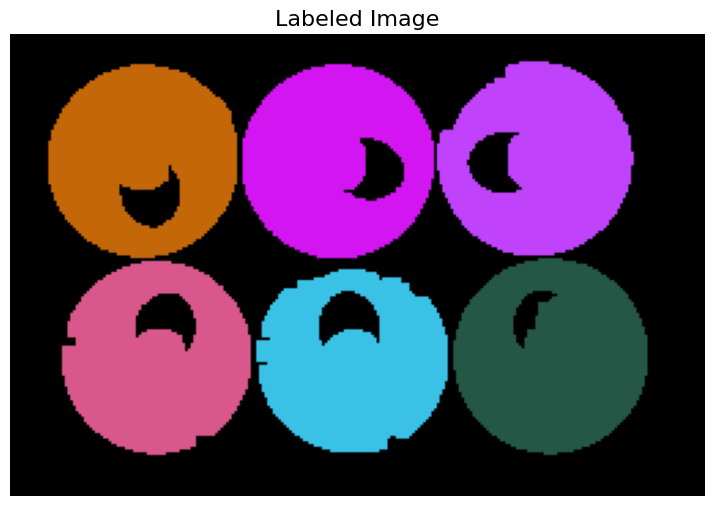

6


In [16]:
def label_to_color_image_fast(label_image):
    # Get unique labels and their indices in the original image
    unique_labels, inverse_indices = np.unique(label_image, return_inverse=True)
    
    # Generate random colors for each unique label
    np.random.seed(0)  # For reproducibility
    colors = np.random.randint(0, 255, size=(len(unique_labels), 3))
    
    # Assign the first color (usually for label 0) as black or any other color for 'no label'
    colors[0] = [0, 0, 0]  # Assuming the first label is 0 and represents 'no label'
    
    # Map each label to its corresponding color
    color_image = colors[inverse_indices].reshape(label_image.shape + (3,))
    
    return color_image


def connectivity_labeling(bin_image):
    label = 1
    label_image = np.zeros_like(bin_image)
    for i in range(label_image.shape[0]):
        for j in range(label_image.shape[1]):
            if bin_image[i, j] == 255:
                if label_image[i, j] == 0: # Pixel not yet labeled
                    # Label all component-connected pixels
                    label_image[i, j] = label
                    queue = [(i, j)]
                    while queue:
                        tail = queue[-1]
                        queue.pop()
                        new_queue = [(k, n) for k in range(tail[0]-1, tail[0]+2) for n in range(tail[1]-1, tail[1]+2) if (k != tail[0] or n != tail[1])
                                     and k >= 0 and k <= label_image.shape[0] - 1
                                      and n >= 0 and n <= label_image.shape[1] - 1 and (bin_image[k, n] == 255) and label_image[k, n] == 0]
                        for pix in new_queue: 
                            label_image[pix] = label
                        queue = new_queue + queue
                    label += 1

    return label_image, label - 1

label_im, counts = connectivity_labeling(morph_image)
rgb_image = label_to_color_image_fast(label_im)

fig, axs = plt.subplots(1, 1, figsize=(10, 6))
axs.imshow(rgb_image)
axs.set_axis_off()
axs.set_title("Labeled Image", fontsize=16)
fig.savefig("Images/labeled_image.png")
plt.show()

print(counts)

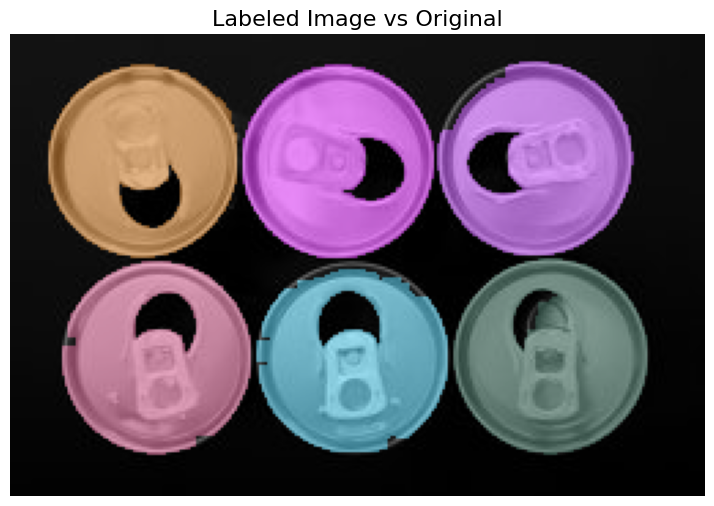

In [17]:
# Superimpose initial image with label image
fig, axs = plt.subplots(1, 1, figsize=(10, 6))
axs.imshow(image, cmap="gray")
axs.imshow(rgb_image, alpha=0.5)
axs.set_axis_off()
axs.set_title("Labeled Image vs Original", fontsize=16)
fig.savefig("Images/labeled_vs_original.png")
plt.show()

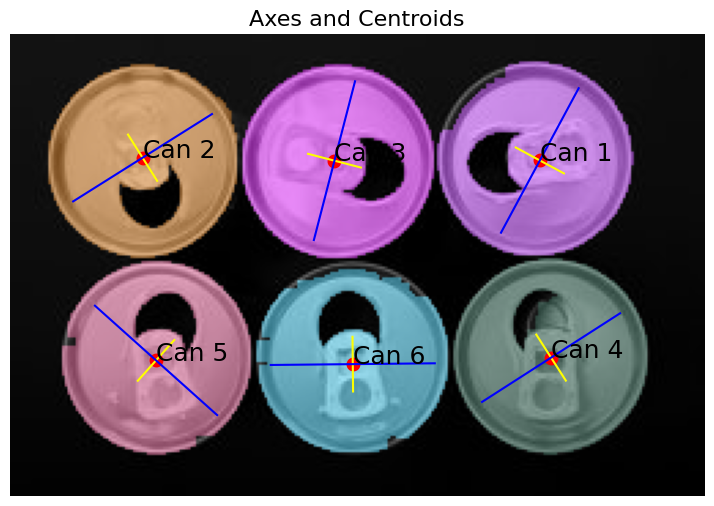

In [18]:
# Calculating Moments
# First we need to segment into different lists for each label
d ={i:[] for i in range(1, counts + 1)}
for i in range(label_im.shape[0]):
    for j in range(label_im.shape[1]):
        if label_im[i, j] != 0:
            d[label_im[i, j]].append((i, j))

xis ={i:[it[1] for it in d[i]] for i in range(1, counts + 1)}
yis ={i:[it[0] for it in d[i]] for i in range(1, counts + 1)}

mx = {i:np.mean(np.array(xis[i])) for i in range(1, counts + 1)}
my = {i:np.mean(np.array(yis[i])) for i in range(1, counts + 1)}
mu01 = {i:np.sum(np.array(xis[i]) - mx[i]) for i in range(1, counts + 1)}
mu10 ={i:np.sum(np.array(yis[i]) - my[i]) for i in range(1, counts + 1)}
mu11 = {i:np.sum((np.array(xis[i]) - mx[i]) * (np.array(yis[i]) - my[i])) for i in range(1, counts + 1)}
mu02 = {i:np.sum((np.array(xis[i]) - mx[i])**2) for i in range(1, counts + 1)}
mu20 = {i:np.sum((np.array(yis[i]) - my[i])**2) for i in range(1, counts + 1)}
thetas = {i:np.arctan(2 * mu11[i]/(mu20[i] - mu02[i] + np.sqrt((mu20[i] - mu02[i])**2 + 4 * mu11[i]**2)  + 1e-10)) + np.pi/2 for i in range(1, counts + 1)}


# Superimpose initial image with label image
fig, axs = plt.subplots(1, 1, figsize=(10, 6))
axs.imshow(image, cmap="gray")
axs.imshow(rgb_image, alpha=0.5)
axs.scatter(mx.values(), my.values(), linewidth=4, color="red")
length1, length2 = 10, 30

# Draw orientation lines
for i in range(1, counts + 1):
    
    x_center, y_center = mx[i], my[i]
    axs.text(x_center, y_center, 'Can {}'.format(i), fontsize=18)
    x_start = x_center + np.sin(thetas[i]) * length1
    x_end = x_center - np.sin(thetas[i])  * length1
    y_start = y_center + np.cos(thetas[i])  * length1
    y_end = y_center - np.cos(thetas[i]) * length1
    axs.plot([x_start, x_end], [y_start, y_end], 'yellow')  # Line color is yellow for visibility

# Draw orientation lines
for i in range(1, counts + 1):
    x_center, y_center = mx[i], my[i]
    x_start = x_center + np.sin(thetas[i] + np.pi / 2) * length2
    x_end = x_center - np.sin(thetas[i] + np.pi / 2)* length2
    y_start = y_center + np.cos(thetas[i] + np.pi / 2) * length2
    y_end = y_center - np.cos(thetas[i] + np.pi / 2) * length2
    axs.plot([x_start, x_end], [y_start, y_end], 'blue')  # Line color is yellow for visibility

axs.set_axis_off()
axs.set_title("Axes and Centroids", fontsize=16)
fig.savefig("Images/centroids_rotations.png")
plt.show()

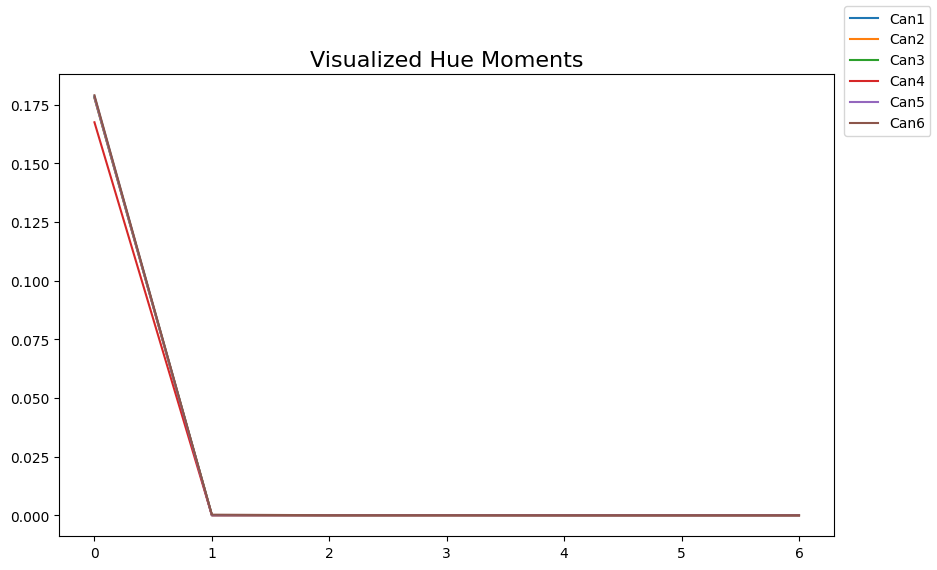

In [19]:
# Calculating Hu moments
mu00 = {i:len(xis[i]) for i in range(1, counts+1)}
mu03 = {i:np.sum((np.array(xis[i]) - mx[i]) ** 3) for i in range(1, counts+1)}
mu30 = {i:np.sum((np.array(yis[i]) - my[i]) ** 3) for i in range(1, counts+1)}
mu21 = {i:np.sum((np.array(xis[i]) - mx[i]) * (np.array(yis[i]) - my[i])**2) for i in range(1, counts + 1)}
mu12 = {i:np.sum((np.array(xis[i]) - mx[i])**2 * (np.array(yis[i]) - my[i])) for i in range(1, counts + 1)}

def calculate_hu_moments(mu20, mu02, mu11, mu30, mu12, mu21, mu03, mu00):
    # Normalized central moments
    nu20 = mu20 / mu00**2
    nu02 = mu02 / mu00**2
    nu11 = mu11 / mu00**2
    nu30 = mu30 / mu00**2.5
    nu12 = mu12 / mu00**2.5
    nu21 = mu21 / mu00**2.5
    nu03 = mu03 / mu00**2.5

    # Hu Moments
    hu1 = nu20 + nu02
    hu2 = (nu20 - nu02)**2 + 4*nu11**2
    hu3 = (nu30 - 3*nu12)**2 + (3*nu21 - nu03)**2
    hu4 = (nu30 + nu12)**2 + (nu21 + nu03)**2
    hu5 = (nu30 - 3*nu12) * (nu30 + nu12) * ((nu30 + nu12)**2 - 3*(nu21 + nu03)**2) + (3*nu21 - nu03) * (nu21 + nu03) * (3*(nu30 + nu12)**2 - (nu21 + nu03)**2)
    hu6 = (nu20 - nu02) * ((nu30 + nu12)**2 - (nu21 + nu03)**2) + 4*nu11 * (nu30 + nu12) * (nu21 + nu03)
    hu7 = (3*nu21 - nu03) * (nu30 + nu12) * ((nu30 + nu12)**2 - 3*(nu21 + nu03)**2) - (nu30 - 3*nu12) * (nu21 + nu03) * (3*(nu30 + nu12)**2 - (nu21 + nu03)**2)

    return hu1, hu2, hu3, hu4, hu5, hu6, hu7

fig, axs = plt.subplots(1, 1, figsize=(10, 6))
for i in range(1, counts+1):
    hu = calculate_hu_moments(mu20[i], mu02[i], mu11[i], mu30[i], mu12[i], mu21[i], mu03[i], mu00[i])
    axs.plot(np.arange(len(hu)), hu, label="Can{}".format(i))
axs.set_title("Visualized Hue Moments", fontsize=16)
fig.legend()
fig.savefig("Images/hue_moments.svg", format="svg")
plt.show()


In [20]:
# PART B: Getting custom shoes_apples.jpg photo
image = cv2.imread("Images/shoes_apples.jpg", cv2.IMREAD_GRAYSCALE)
image = np.invert(image)
init_size = image.shape
reduced_size = [int(init_size[1] * 0.2), int(init_size[0] * 0.2)]
image = cv2.resize(image, reduced_size, 
               interpolation = cv2.INTER_LINEAR)
fig, axs = plt.subplots(1, 1, figsize=(10, 6))
axs.imshow(image, cmap="gray")
axs.set_axis_off()
fig.savefig("Images/apples_shoes.jpg")
plt.show()

TypeError: bad operand type for unary ~: 'NoneType'

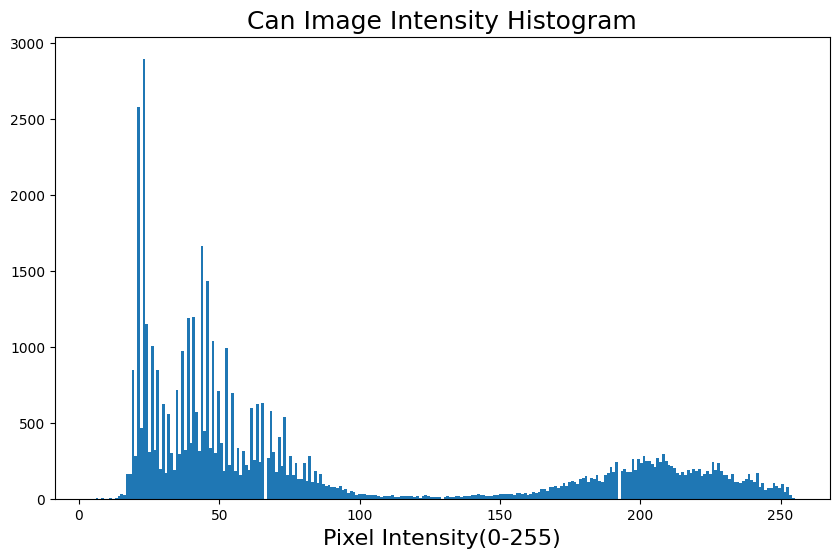

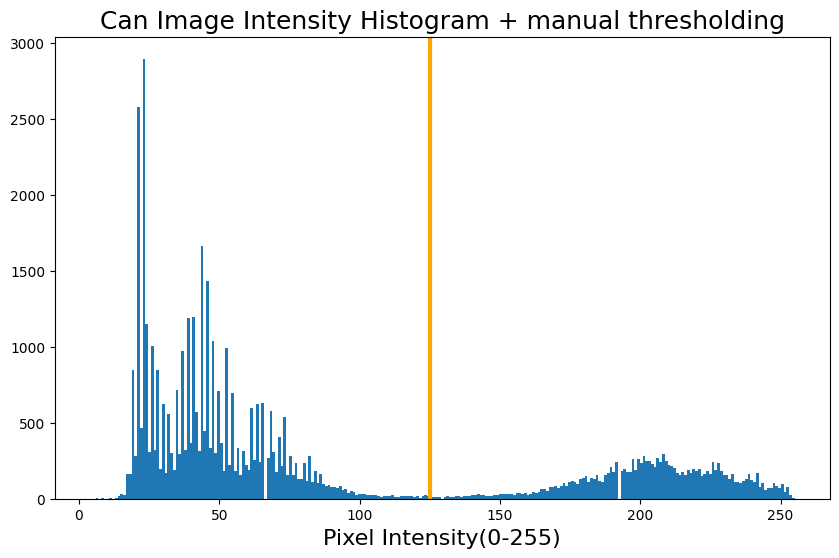

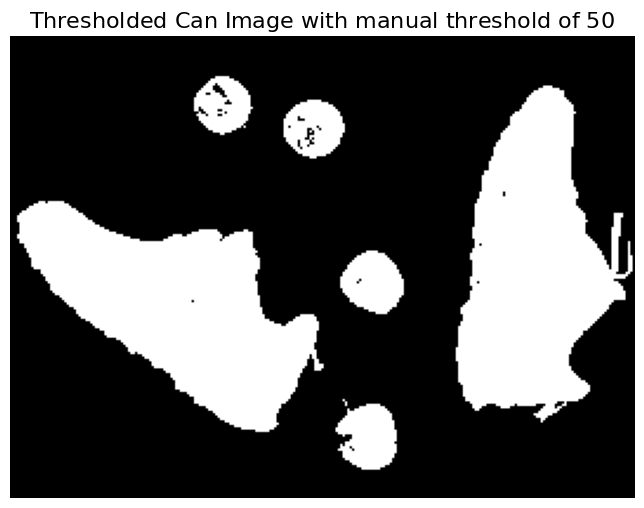

In [ ]:
# Let us first get a histogram of image intensities
fig, axs = plt.subplots(1, 1, figsize=(10, 6))
axs.hist(image.flatten(), bins=255)
axs.set_title("Can Image Intensity Histogram", fontsize=18)
axs.set_xlabel("Pixel Intensity(0-255)", fontsize=16)
fig.savefig("Images/apples_hist.svg", format="svg")

ret, bin_image = cv2.threshold(image, 125, 255, cv2.THRESH_BINARY)

# Let us first get a histogram of image intensities
fig, axs = plt.subplots(1, 1, figsize=(10, 6))
axs.hist(image.flatten(), bins=255)
axs.set_title("Can Image Intensity Histogram + manual thresholding", fontsize=18)
axs.set_xlabel("Pixel Intensity(0-255)", fontsize=16)
axs.axvline(ret, color="orange", linewidth=3)
fig.savefig("Images/apples_hist_thresh_manual.svg", format="svg")
plt.show()

# Threshold with an obvious choice of around 40-50 intensity

fig, axs = plt.subplots(1, 1, figsize=(10, 6))
axs.imshow(bin_image, cmap="gray")
axs.set_axis_off()
axs.set_title("Thresholded Can Image with manual threshold of $50$", fontsize=16)
fig.savefig("Images/apples_thresh_manual.png")
plt.show()

Otsu's threshold is:  124


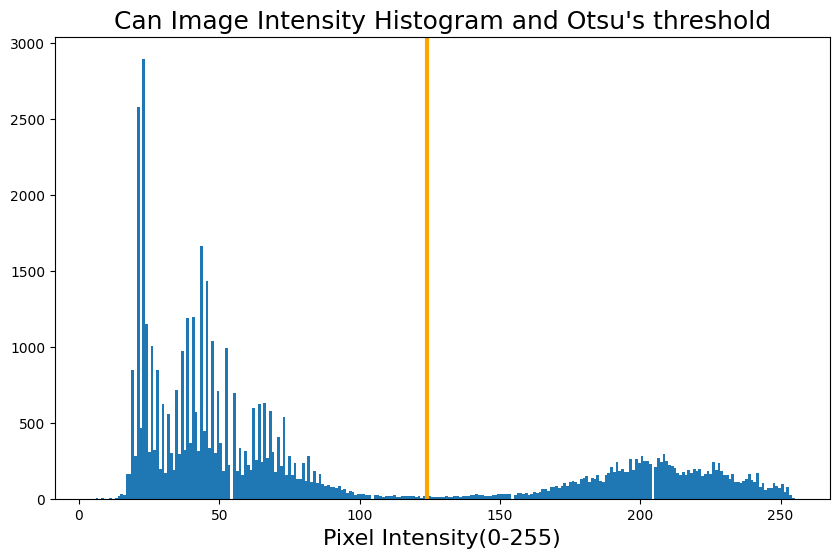

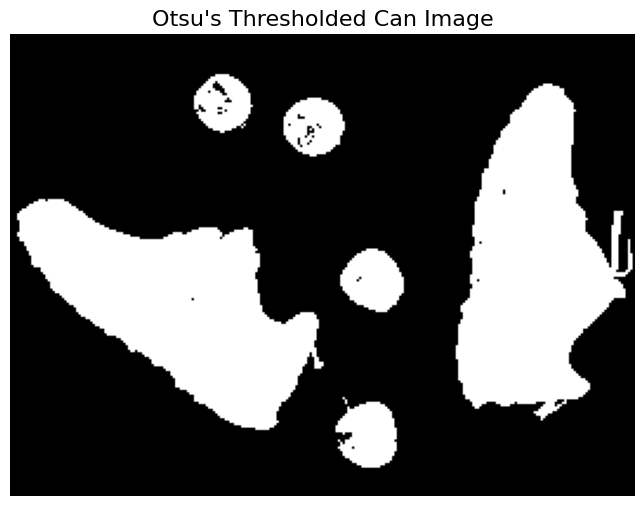

In [ ]:
thresh, bin_image = otsus_thresholding(image)

print("Otsu's threshold is: ", thresh)

# Let us first get a histogram of image intensities
fig, axs = plt.subplots(1, 1, figsize=(10, 6))
axs.hist(image.flatten(), bins=256)
axs.set_title("Can Image Intensity Histogram and Otsu's threshold", fontsize=18)
axs.set_xlabel("Pixel Intensity(0-255)", fontsize=16)
axs.axvline(thresh, color="orange", linewidth=3)
fig.savefig("Images/apples_otsus_hist.svg", format="svg")
plt.show()


fig, axs = plt.subplots(1, 1, figsize=(10, 6))
axs.imshow(bin_image, cmap="gray")
axs.set_axis_off()
axs.set_title("Otsu's Thresholded Can Image", fontsize=16)
fig.savefig("Images/apples_thresh_otsus.png")
plt.show()

thresh, bin_image = cv2.threshold(image, thresh, 255, cv2.THRESH_BINARY)

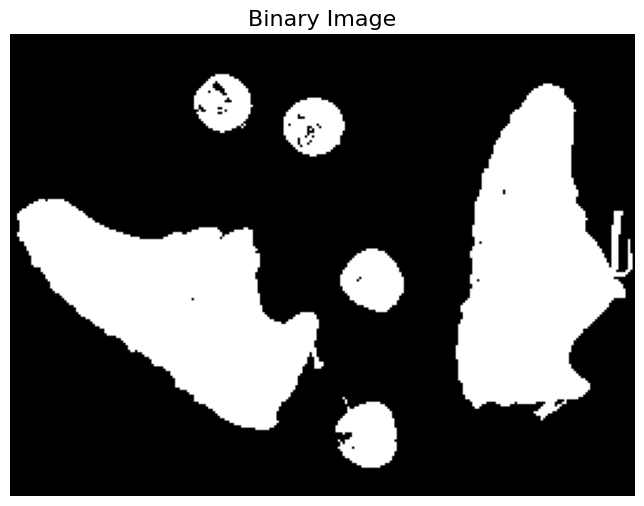

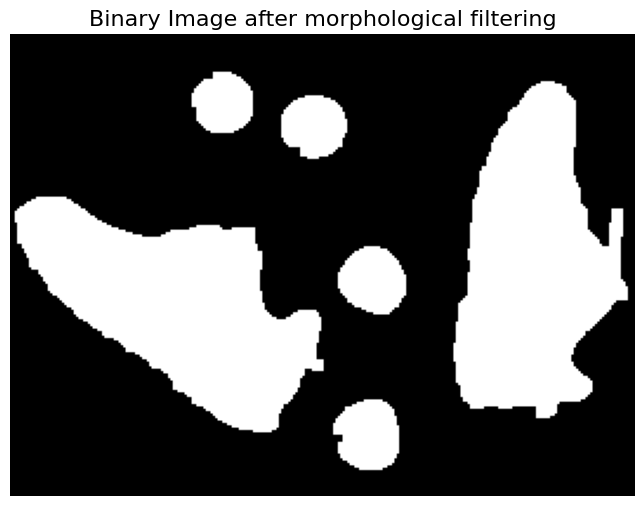

In [ ]:
morph_image = opening(bin_image, kernel_erosion=3, kernel_dilation=5)
morph_image = closing(morph_image, kernel_erosion=3, kernel_dilation=3)
#morph_image = dilation(morph_image, kernel_size=3)

fig, axs = plt.subplots(1, 1, figsize=(10, 6))
axs.imshow(bin_image, cmap="gray")
axs.set_axis_off()
axs.set_title("Binary Image", fontsize=16)
fig.savefig("Images/apples_binary_image.png")
plt.show()

fig, axs = plt.subplots(1, 1, figsize=(10, 6))
axs.imshow(morph_image, cmap="gray")
axs.set_axis_off()
axs.set_title("Binary Image after morphological filtering", fontsize=16)
fig.savefig("Images/apples_Binary_after.png")
plt.show()


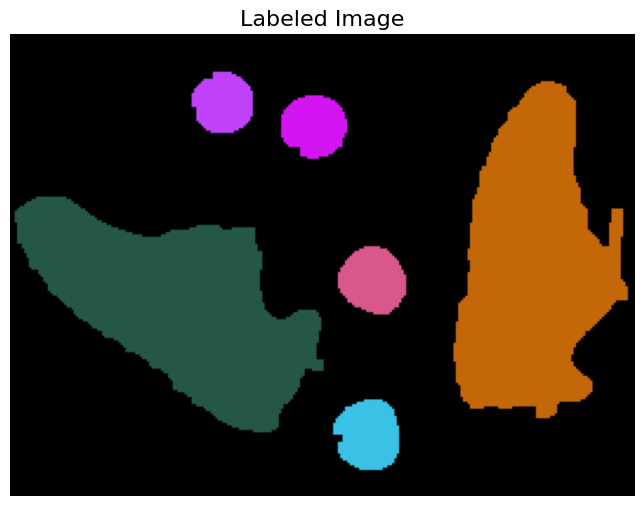

In [ ]:
label_im, counts = connectivity_labeling(morph_image)
rgb_image = label_to_color_image_fast(label_im)

fig, axs = plt.subplots(1, 1, figsize=(10, 6))
axs.imshow(rgb_image)
axs.set_axis_off()
axs.set_title("Labeled Image", fontsize=16)
fig.savefig("Images/apples_labeled_image.png")
plt.show()

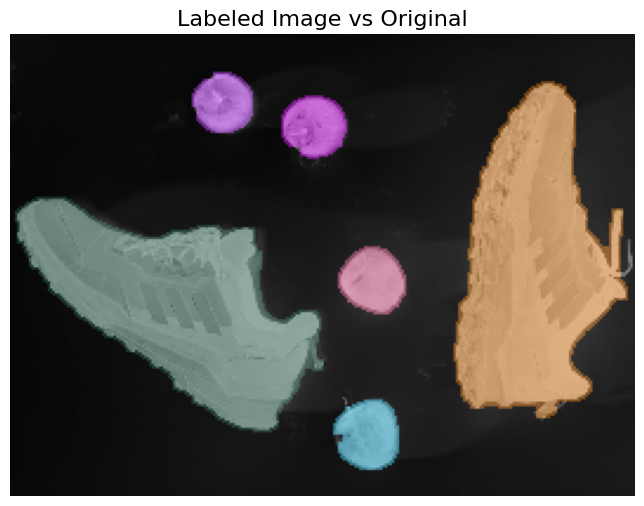

In [ ]:
# Superimpose initial image with label image
fig, axs = plt.subplots(1, 1, figsize=(10, 6))
axs.imshow(image, cmap="gray")
axs.imshow(rgb_image, alpha=0.5)
axs.set_axis_off()
axs.set_title("Labeled Image vs Original", fontsize=16)
fig.savefig("Images/apples_labeled_vs_original.png")
plt.show()

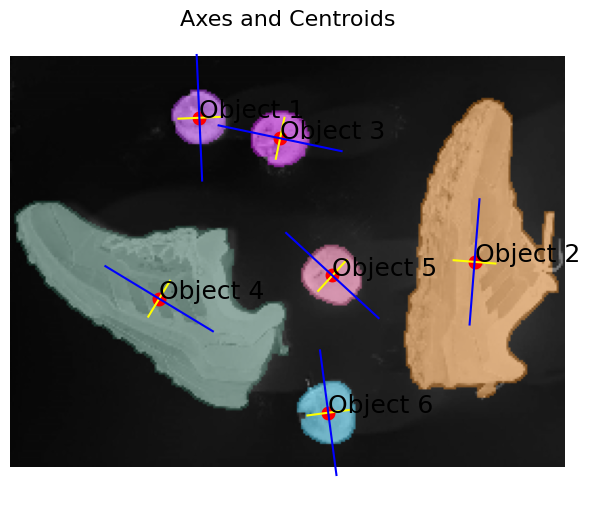

In [ ]:
# Calculating Moments
# First we need to segment into different lists for each label
d ={i:[] for i in range(1, counts + 1)}
for i in range(label_im.shape[0]):
    for j in range(label_im.shape[1]):
        if label_im[i, j] != 0:
            d[label_im[i, j]].append((i, j))

xis ={i:[it[1] for it in d[i]] for i in range(1, counts + 1)}
yis ={i:[it[0] for it in d[i]] for i in range(1, counts + 1)}

mx = {i:np.mean(np.array(xis[i])) for i in range(1, counts + 1)}
my = {i:np.mean(np.array(yis[i])) for i in range(1, counts + 1)}
mu01 = {i:np.sum(np.array(xis[i]) - mx[i]) for i in range(1, counts + 1)}
mu10 ={i:np.sum(np.array(yis[i]) - my[i]) for i in range(1, counts + 1)}
mu11 = {i:np.sum((np.array(xis[i]) - mx[i]) * (np.array(yis[i]) - my[i])) for i in range(1, counts + 1)}
mu02 = {i:np.sum((np.array(xis[i]) - mx[i])**2) for i in range(1, counts + 1)}
mu20 = {i:np.sum((np.array(yis[i]) - my[i])**2) for i in range(1, counts + 1)}
thetas = {i:np.arctan(2 * mu11[i]/(mu20[i] - mu02[i] + np.sqrt((mu20[i] - mu02[i])**2 + 4 * mu11[i]**2)  + 1e-10)) + np.pi/2 for i in range(1, counts + 1)}


# Superimpose initial image with label image
fig, axs = plt.subplots(1, 1, figsize=(10, 6))
axs.imshow(image, cmap="gray")
axs.imshow(rgb_image, alpha=0.5)
axs.scatter(mx.values(), my.values(), linewidth=4, color="red")
length1, length2 = 10, 30

# Draw orientation lines
for i in range(1, counts + 1):
    
    x_center, y_center = mx[i], my[i]
    axs.text(x_center, y_center, 'Object {}'.format(i), fontsize=18)
    x_start = x_center + np.sin(thetas[i]) * length1
    x_end = x_center - np.sin(thetas[i])  * length1
    y_start = y_center + np.cos(thetas[i])  * length1
    y_end = y_center - np.cos(thetas[i]) * length1
    axs.plot([x_start, x_end], [y_start, y_end], 'yellow')  # Line color is yellow for visibility

# Draw orientation lines
for i in range(1, counts + 1):
    x_center, y_center = mx[i], my[i]
    x_start = x_center + np.sin(thetas[i] + np.pi / 2) * length2
    x_end = x_center - np.sin(thetas[i] + np.pi / 2)* length2
    y_start = y_center + np.cos(thetas[i] + np.pi / 2) * length2
    y_end = y_center - np.cos(thetas[i] + np.pi / 2) * length2
    axs.plot([x_start, x_end], [y_start, y_end], 'blue')  # Line color is yellow for visibility

axs.set_axis_off()
axs.set_title("Axes and Centroids", fontsize=16)
fig.savefig("Images/apples_centroids_rotations.png")
plt.show()

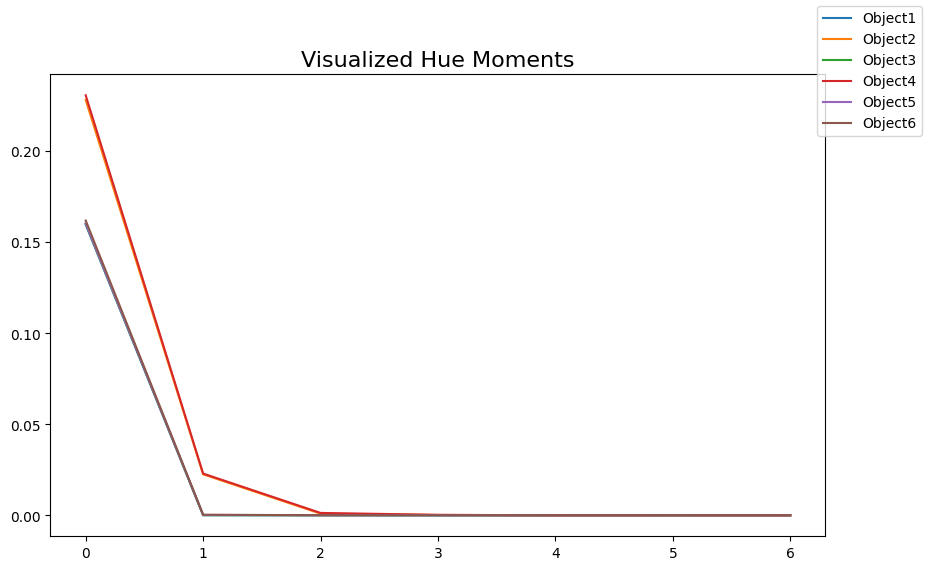

[0.22745098 0.75686275 0.90196078]


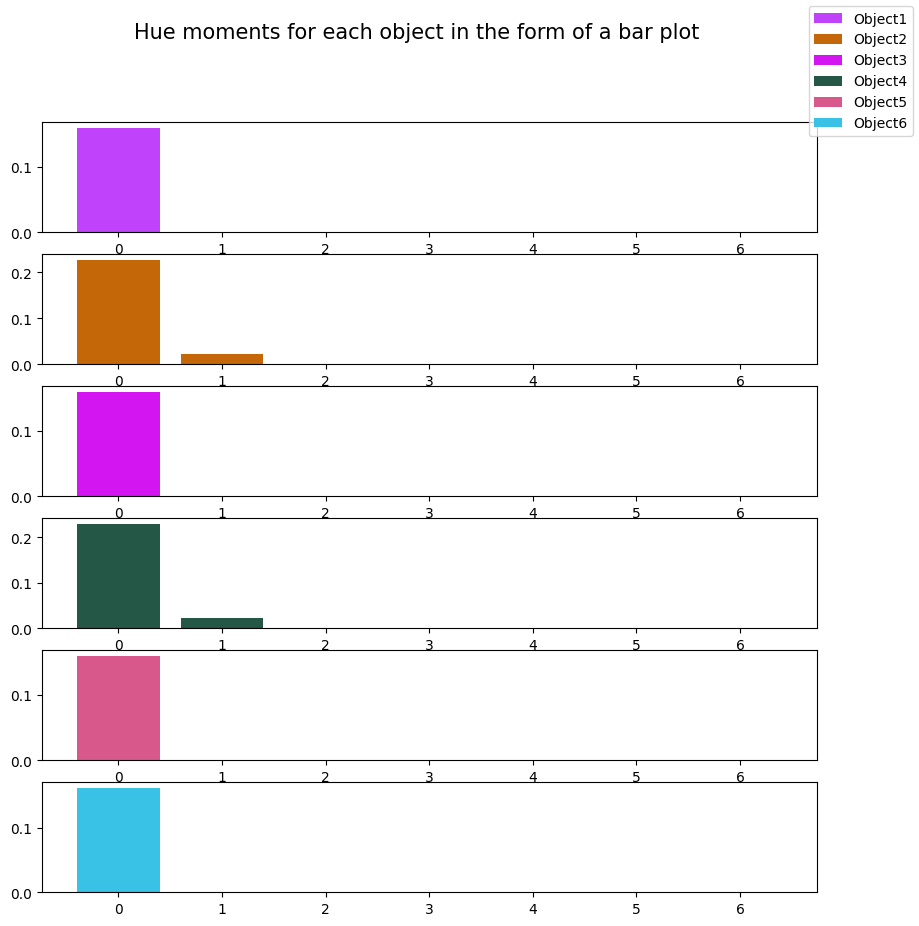

In [ ]:
# Calculating Hu moments
mu00 = {i:len(xis[i]) for i in range(1, counts+1)}
mu03 = {i:np.sum((np.array(xis[i]) - mx[i]) ** 3) for i in range(1, counts+1)}
mu30 = {i:np.sum((np.array(yis[i]) - my[i]) ** 3) for i in range(1, counts+1)}
mu21 = {i:np.sum((np.array(xis[i]) - mx[i]) * (np.array(yis[i]) - my[i])**2) for i in range(1, counts + 1)}
mu12 = {i:np.sum((np.array(xis[i]) - mx[i])**2 * (np.array(yis[i]) - my[i])) for i in range(1, counts + 1)}

def calculate_hu_moments(mu20, mu02, mu11, mu30, mu12, mu21, mu03, mu00):
    # Normalized central moments
    nu20 = mu20 / mu00**2
    nu02 = mu02 / mu00**2
    nu11 = mu11 / mu00**2
    nu30 = mu30 / mu00**2.5
    nu12 = mu12 / mu00**2.5
    nu21 = mu21 / mu00**2.5
    nu03 = mu03 / mu00**2.5

    # Hu Moments
    hu1 = nu20 + nu02
    hu2 = (nu20 - nu02)**2 + 4*nu11**2
    hu3 = (nu30 - 3*nu12)**2 + (3*nu21 - nu03)**2
    hu4 = (nu30 + nu12)**2 + (nu21 + nu03)**2
    hu5 = (nu30 - 3*nu12) * (nu30 + nu12) * ((nu30 + nu12)**2 - 3*(nu21 + nu03)**2) + (3*nu21 - nu03) * (nu21 + nu03) * (3*(nu30 + nu12)**2 - (nu21 + nu03)**2)
    hu6 = (nu20 - nu02) * ((nu30 + nu12)**2 - (nu21 + nu03)**2) + 4*nu11 * (nu30 + nu12) * (nu21 + nu03)
    hu7 = (3*nu21 - nu03) * (nu30 + nu12) * ((nu30 + nu12)**2 - 3*(nu21 + nu03)**2) - (nu30 - 3*nu12) * (nu21 + nu03) * (3*(nu30 + nu12)**2 - (nu21 + nu03)**2)

    return hu1, hu2, hu3, hu4, hu5, hu6, hu7

fig, axs = plt.subplots(1, 1, figsize=(10, 6))
for i in range(1, counts+1):
    hu = calculate_hu_moments(mu20[i], mu02[i], mu11[i], mu30[i], mu12[i], mu21[i], mu03[i], mu00[i])
    axs.plot(np.arange(len(hu)), hu, label="Object{}".format(i))
axs.set_title("Visualized Hue Moments", fontsize=16)
fig.legend()
fig.savefig("Images/apples_hue_moments_lines.svg", format="svg")
plt.show()


unique_labels, inverse_indices = np.unique(rgb_image, return_inverse=True)

# Generate random colors for each unique label
np.random.seed(0)  # For reproducibility
colors = np.random.randint(0, 255, size=(len(unique_labels), 3)) / 255.0

print(colors[i])
fig, axs = plt.subplots(6, 1, figsize=(10, 10))
for i in range(1, counts+1):
    hu = calculate_hu_moments(mu20[i], mu02[i], mu11[i], mu30[i], mu12[i], mu21[i], mu03[i], mu00[i])
    axs[i-1].bar(np.arange(len(hu)), hu, label="Object{}".format(i), color=colors[i])

fig.suptitle("Hue moments for each object in the form of a bar plot", fontsize=15)
fig.legend()
fig.savefig("Images/apples_hue_moments_bar.svg", format="svg")
plt.show()
